In [1]:
using Pkg
Pkg.activate("D:\\Science\\Code\\Julia\\envr")

  Activating project at `D:\Science\Code\Julia\envr`


In [2]:
using StaticArrays, DifferentialEquations, DynamicalSystems, CairoMakie

In [3]:
function TM(u, p, t)

    U(y) = U0 + ΔU0 / ( 1 + exp( -50*(y-ythr) ) )
    σ(x) = 1 / ( 1 + exp( -20*(x-xthr) ) )

    E, x, y = u
    α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0 = p

    du1 = (-E + α * log( 1 + exp( (J * U(y) * x * E + I0  ) / (α) ) ) ) / τ
    du2 = (1-x)/τD - U(y)*x*E
    du3 = (-y)/τy+β*σ(x)
    return SVector(du1, du2, du3)
end;

In [4]:
function output(idx_I0, idx_U0, I0, U0, u0)
    println("Индекс I0: $idx_I0; I0: $I0");flush(stdout)
    println("Индекс U0: $idx_U0; U0: $U0");flush(stdout)
    println("Начальные условия: $u0");flush(stdout)
end
function output(idx_U0,U0, u0)
    println("Индекс U0: $idx_U0; U0: $U0");flush(stdout)
    println("Начальные условия: $u0");flush(stdout)
end
function output_end_iter(ΛΛ, u0_lc)
    println("Спектр: $(ΛΛ)");flush(stdout)
    println("Последняя точка: $(u0_lc)");flush(stdout)
end
function separate()
    println();flush(stdout)
    println("---------");flush(stdout)
end;

In [5]:
t = 150.0; tt = 250.0; tstep = 0.001
trange = range(0.0, t, step = tstep)
integ_set = (alg = RK4(), adaptive = false, dt = tstep);

In [6]:
const τ = 0.013;  const τD = 0.080;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4
const α = 1.58;  U0 = 0.3;  const ΔU0 = 0.305; I0 = -1.40;

In [7]:
u0 = SA[17.6055, 0.6181, 0.429232]

3-element SVector{3, Float64} with indices SOneTo(3):
 17.6055
  0.6181
  0.429232

In [39]:
I0range = range( -1.40, -1.87036, length = 50 )
U0range = range( 0.3,  0.5, length = 50)

0.3:0.004081632653061225:0.5

In [40]:
Λs = zeros(length(I0range), length(U0range), 3)
u0s = zeros(length(I0range), length(U0range), 3);

In [41]:
function init_ds(U0_, u0_lc)
    p = [α, τ, τD, τy, J, xthr, ythr, U0_, ΔU0, β, I0range[1]]
    ds = ContinuousDynamicalSystem(TM, u0_lc, p)
    return ds
end
function init_ds(U0_, I0_, u0_lc)
    p = [α, τ, τD, τy, J, xthr, ythr, U0_, ΔU0, β, I0_]
    ds = ContinuousDynamicalSystem(TM, u0_lc, p)
    return ds
end
function goto_attractor(ds_)
    tr = trajectory(ds_, t; Ttr = tt, diffeq = integ_set)
    u0_lc = tr[end]
    return u0_lc
end
function spectrum(ds_)
    ΛΛ = lyapunovspectrum(ds_, t; diffeq = integ_set)
    return ΛΛ
end
function save_output(idx_U0, ΛΛ, u0_lc)
    Λs[1, idx_U0, :] = ΛΛ
    u0s[1, idx_U0, :] = u0_lc
end
function save_output(index_I0, idx_U0, ΛΛ, u0_lc)
    Λs[index_I0, idx_U0, :] = ΛΛ
    u0s[index_I0, idx_U0, :] = u0_lc
end

save_output (generic function with 2 methods)

In [42]:
for (idx_U0, U0_) in enumerate(U0range)
    
    if idx_U0 == 1 # Проверка на первую итерацию
        global u0_lc = u0
    end
    
    output(idx_U0, U0_, u0_lc) # Вывод
    ds = init_ds(U0_, u0_lc) # Инициализация системы
    u0_lc = goto_attractor(ds) # Выход на аттрактор
    ΛΛ = spectrum(ds) # Вычисление спектра
    save_output(idx_U0, ΛΛ, u0_lc) # Сохранение значений
    output_end_iter(ΛΛ, u0_lc) # Вывод
    separate()
    
end

Индекс U0: 1; U0: 0.3
Начальные условия: [17.6055, 0.6181, 0.429232]
Спектр: [0.019431975297390696, -2.7527120087512706, -2.820003482631533]
Последняя точка: [6.128004599054316, 0.7187832580003417, 0.41649927269079234]

---------
Индекс U0: 2; U0: 0.3040816326530612
Начальные условия: [6.128004599054316, 0.7187832580003417, 0.41649927269079234]
Спектр: [0.036337575522286836, -2.782190027038819, -2.837234216542707]
Последняя точка: [13.431412171635934, 0.6046280515264753, 0.42313574330643194]

---------
Индекс U0: 3; U0: 0.3081632653061224
Начальные условия: [13.431412171635934, 0.6046280515264753, 0.42313574330643194]
Спектр: [0.032573881947814375, -2.8026981032222533, -2.868579387232224]
Последняя точка: [9.305250739332083, 0.6451506361176265, 0.4175739019180914]

---------
Индекс U0: 4; U0: 0.3122448979591837
Начальные условия: [9.305250739332083, 0.6451506361176265, 0.4175739019180914]
Спектр: [0.030276255832834036, -2.8471136587470145, -2.8777381767767034]
Последняя точка: [4.10507

Последняя точка: [13.255325205491628, 0.5874927014154064, 0.3919801591817549]

---------
Индекс U0: 31; U0: 0.42244897959183675
Начальные условия: [13.255325205491628, 0.5874927014154064, 0.3919801591817549]
Спектр: [0.03196044049144115, -3.0795236413967753, -3.1375782064716553]
Последняя точка: [19.277732420305085, 0.589608729712729, 0.3956733617872022]

---------
Индекс U0: 32; U0: 0.42653061224489797
Начальные условия: [19.277732420305085, 0.589608729712729, 0.3956733617872022]
Спектр: [0.026162455811159845, -3.06085444118073, -3.1367008637306717]
Последняя точка: [12.545972569627228, 0.5970115834899047, 0.3887310390512674]

---------
Индекс U0: 33; U0: 0.4306122448979592
Начальные условия: [12.545972569627228, 0.5970115834899047, 0.3887310390512674]
Спектр: [0.027927355334679747, -3.0651479788123073, -3.1147526875044065]
Последняя точка: [6.998193154428695, 0.686166781108289, 0.38191103956692435]

---------
Индекс U0: 34; U0: 0.4346938775510204
Начальные условия: [6.998193154428695

In [47]:
for (idx_U0, U0_) in enumerate(U0range)
    for (idx_I0, I0_) in enumerate(I0range)
        
        if idx_I0 == 1
            continue
        end
        
        u0_lc = u0s[idx_I0 - 1, idx_U0, :]
        output(idx_I0, idx_U0, I0_, U0_, u0_lc)
        ds = init_ds(U0_, I0_, u0_lc)
        u0_lc = goto_attractor(ds) # Выход на аттрактор
        ΛΛ = spectrum(ds) # Вычисление спектра
        save_output(idx_I0, idx_U0, ΛΛ, u0_lc)
        output_end_iter(ΛΛ, u0_lc)
        separate()
    end
end

Индекс I0: 2; I0: -1.4095991836734694
Индекс U0: 1; U0: 0.3
Начальные условия: [6.128004599054316, 0.7187832580003417, 0.41649927269079234]
Спектр: [0.004720386053339522, -2.6894722591792966, -2.7585631849889323]
Последняя точка: [4.631416518558781, 0.8255195820262999, 0.4260423256838662]

---------
Индекс I0: 3; I0: -1.4191983673469388
Индекс U0: 1; U0: 0.3
Начальные условия: [4.631416518558781, 0.8255195820262999, 0.4260423256838662]
Спектр: [0.03778151409098712, -2.6688825164838215, -2.709601364505273]
Последняя точка: [18.104295308032224, 0.6449929607344908, 0.43199155306532994]

---------
Индекс I0: 4; I0: -1.428797551020408
Индекс U0: 1; U0: 0.3
Начальные условия: [18.104295308032224, 0.6449929607344908, 0.43199155306532994]
Спектр: [0.031251831263936, -2.2096251849970945, -3.065347707219164]
Последняя точка: [8.413053946222998, 0.6623691122867194, 0.41980981315684324]

---------
Индекс I0: 5; I0: -1.4383967346938775
Индекс U0: 1; U0: 0.3
Начальные условия: [8.413053946222998, 0.

Спектр: [0.04200614779601701, -0.5879319611724546, -5.186185690530016]
Последняя точка: [2.8024285974718692, 0.8224264156673435, 0.4235323119037823]

---------
Индекс I0: 30; I0: -1.6783763265306122
Индекс U0: 1; U0: 0.3
Начальные условия: [2.8024285974718692, 0.8224264156673435, 0.4235323119037823]
Спектр: [0.029081089547170605, -0.4058455122325305, -5.313396480184312]
Последняя точка: [13.61649836122944, 0.6340570921379065, 0.43956912295632916]

---------
Индекс I0: 31; I0: -1.6879755102040817
Индекс U0: 1; U0: 0.3
Начальные условия: [13.61649836122944, 0.6340570921379065, 0.43956912295632916]
Спектр: [0.029310612216714983, -0.14671898426969543, -5.447199713547497]
Последняя точка: [1.6782960306835997, 0.9244239076305928, 0.4553395595256109]

---------
Индекс I0: 32; I0: -1.697574693877551
Индекс U0: 1; U0: 0.3
Начальные условия: [1.6782960306835997, 0.9244239076305928, 0.4553395595256109]
Спектр: [0.02790237832465771, -0.10168836435447981, -5.228543668026115]
Последняя точка: [21.68

Спектр: [0.04263428634639176, -0.7143058877573865, -4.321796021090538]
Последняя точка: [11.626865941854575, 0.612053093221063, 0.42350557825960333]

---------
Индекс I0: 8; I0: -1.4671942857142857
Индекс U0: 2; U0: 0.3040816326530612
Начальные условия: [11.626865941854575, 0.612053093221063, 0.42350557825960333]
Спектр: [0.015334471707121612, -0.43842767440858516, -4.461321240610851]
Последняя точка: [17.653032713224587, 0.5956581737909139, 0.4299780776611772]

---------
Индекс I0: 9; I0: -1.4767934693877551
Индекс U0: 2; U0: 0.3040816326530612
Начальные условия: [17.653032713224587, 0.5956581737909139, 0.4299780776611772]
Спектр: [0.01741260290609392, -0.25671685711029957, -4.5547280959830765]
Последняя точка: [16.05143969179569, 0.7087046386707528, 0.43568103681203263]

---------
Индекс I0: 10; I0: -1.4863926530612246
Индекс U0: 2; U0: 0.3040816326530612
Начальные условия: [16.05143969179569, 0.7087046386707528, 0.43568103681203263]
Спектр: [0.003281225874460253, -0.0631309266068043

Спектр: [0.011251699849524793, -0.4533284142758363, -5.4385124671913845]
Последняя точка: [11.210637990919953, 0.6661199116816696, 0.42254092455943665]

---------
Индекс I0: 34; I0: -1.7167730612244898
Индекс U0: 2; U0: 0.3040816326530612
Начальные условия: [11.210637990919953, 0.6661199116816696, 0.42254092455943665]
Спектр: [0.030541851139433057, -0.07994175507939408, -5.575624308983556]
Последняя точка: [2.6270013106353294, 0.9147306714763118, 0.4699727185978992]

---------
Индекс I0: 35; I0: -1.7263722448979593
Индекс U0: 2; U0: 0.3040816326530612
Начальные условия: [2.6270013106353294, 0.9147306714763118, 0.4699727185978992]
Спектр: [0.4046076384861687, -0.0061981894469536215, -5.253395999207936]
Последняя точка: [12.908645869091902, 0.6357828725292969, 0.4338606534426427]

---------
Индекс I0: 36; I0: -1.7359714285714285
Индекс U0: 2; U0: 0.3040816326530612
Начальные условия: [12.908645869091902, 0.6357828725292969, 0.4338606534426427]
Спектр: [0.02097274027105197, -0.17505538466

Спектр: [0.005997044128394249, -0.08777197076913401, -4.678963665887425]
Последняя точка: [6.45722022316548, 0.6993421959106845, 0.4184871094984172]

---------
Индекс I0: 11; I0: -1.4959918367346938
Индекс U0: 3; U0: 0.3081632653061224
Начальные условия: [6.45722022316548, 0.6993421959106845, 0.4184871094984172]
Спектр: [0.03792653872216426, -0.6056580837480556, -4.157333271015051]
Последняя точка: [4.2788859568153015, 0.7741352265335947, 0.4163156393254485]

---------
Индекс I0: 12; I0: -1.5055910204081633
Индекс U0: 3; U0: 0.3081632653061224
Начальные условия: [4.2788859568153015, 0.7741352265335947, 0.4163156393254485]
Спектр: [0.033061303493021256, -1.6525795621465682, -3.067810549523259]
Последняя точка: [12.824080445238403, 0.7724820451498826, 0.4401091816886238]

---------
Индекс I0: 13; I0: -1.5151902040816327
Индекс U0: 3; U0: 0.3081632653061224
Начальные условия: [12.824080445238403, 0.7724820451498826, 0.4401091816886238]
Спектр: [0.03669780933924694, -2.315960548400357, -2.

Спектр: [0.042138627541207216, -0.2834817798651407, -5.570023903776859]
Последняя точка: [8.225434424797466, 0.6895929459442379, 0.4273918539045163]

---------
Индекс I0: 37; I0: -1.745570612244898
Индекс U0: 3; U0: 0.3081632653061224
Начальные условия: [8.225434424797466, 0.6895929459442379, 0.4273918539045163]
Спектр: [0.013692583898665631, -0.7822013395563819, -4.805339740458224]
Последняя точка: [7.778627686908363, 0.6973191217312362, 0.42547237405102356]

---------
Индекс I0: 38; I0: -1.7551697959183674
Индекс U0: 3; U0: 0.3081632653061224
Начальные условия: [7.778627686908363, 0.6973191217312362, 0.42547237405102356]
Спектр: [0.055293883565034015, -0.11114186741295898, -5.637188924337078]
Последняя точка: [1.3290527750165269, 0.9295368080452778, 0.4531326295700659]

---------
Индекс I0: 39; I0: -1.7647689795918367
Индекс U0: 3; U0: 0.3081632653061224
Начальные условия: [1.3290527750165269, 0.9295368080452778, 0.4531326295700659]
Спектр: [0.023599030532577246, -0.29044918697402516

Спектр: [0.044677333112717724, -2.361905352890847, -2.417714349977787]
Последняя точка: [6.549736675319186, 0.6941419441757667, 0.42109303562803985]

---------
Индекс I0: 14; I0: -1.524789387755102
Индекс U0: 4; U0: 0.3122448979591837
Начальные условия: [6.549736675319186, 0.6941419441757667, 0.42109303562803985]
Спектр: [0.04368467900895805, -1.3507143263822394, -3.396076996506762]
Последняя точка: [19.13045933008119, 0.6971098753871767, 0.4415797972442804]

---------
Индекс I0: 15; I0: -1.5343885714285714
Индекс U0: 4; U0: 0.3122448979591837
Начальные условия: [19.13045933008119, 0.6971098753871767, 0.4415797972442804]
Спектр: [0.021182783913117013, -0.5926801076618896, -4.103258530198283]
Последняя точка: [11.749478739740384, 0.6315782665866277, 0.4192171876797108]

---------
Индекс I0: 16; I0: -1.543987755102041
Индекс U0: 4; U0: 0.3122448979591837
Начальные условия: [11.749478739740384, 0.6315782665866277, 0.4192171876797108]
Спектр: [0.027253311920947525, -0.16386539926539886, -4

Спектр: [0.048260120495359445, -0.16036272960378156, -5.5590186029653905]
Последняя точка: [1.7786697893327157, 0.8906865695885307, 0.43846787876906285]

---------
Индекс I0: 40; I0: -1.774368163265306
Индекс U0: 4; U0: 0.3122448979591837
Начальные условия: [1.7786697893327157, 0.8906865695885307, 0.43846787876906285]
Спектр: [0.03445853937226812, -0.1726230297716543, -5.499458908684119]
Последняя точка: [9.568747231264409, 0.5976514830582501, 0.46623871306256076]

---------
Индекс I0: 41; I0: -1.7839673469387756
Индекс U0: 4; U0: 0.3122448979591837
Начальные условия: [9.568747231264409, 0.5976514830582501, 0.46623871306256076]
Спектр: [0.03700908453445044, -0.38546905415403865, -6.210215079224782]
Последняя точка: [9.370032961251646, 0.7198625262472726, 0.42507402919077075]

---------
Индекс I0: 42; I0: -1.7935665306122448
Индекс U0: 4; U0: 0.3122448979591837
Начальные условия: [9.370032961251646, 0.7198625262472726, 0.42507402919077075]
Спектр: [0.04098473147618716, -3.34427181519916

Последняя точка: [5.539143128082907, 0.7504008871614435, 0.4215797344108755]

---------
Индекс I0: 17; I0: -1.5535869387755101
Индекс U0: 5; U0: 0.3163265306122449
Начальные условия: [5.539143128082907, 0.7504008871614435, 0.4215797344108755]
Спектр: [0.0444754792669271, -0.5667639171776314, -4.1236837843971115]
Последняя точка: [5.984785913007151, 0.7274840297613846, 0.4120608160307908]

---------
Индекс I0: 18; I0: -1.5631861224489796
Индекс U0: 5; U0: 0.3163265306122449
Начальные условия: [5.984785913007151, 0.7274840297613846, 0.4120608160307908]
Спектр: [0.04567311964039298, -0.21757591894475986, -4.376356397783233]
Последняя точка: [3.1208912356870346, 0.8665330868753227, 0.42981497285807446]

---------
Индекс I0: 19; I0: -1.572785306122449
Индекс U0: 5; U0: 0.3163265306122449
Начальные условия: [3.1208912356870346, 0.8665330868753227, 0.42981497285807446]
Спектр: [0.24346846067006983, 0.005598857385561518, -4.740798770696485]
Последняя точка: [2.518856457627971, 0.87609041702572

Последняя точка: [9.103273286321999, 0.66517911692008, 0.46070333007969494]

---------
Индекс I0: 43; I0: -1.8031657142857143
Индекс U0: 5; U0: 0.3163265306122449
Начальные условия: [9.103273286321999, 0.66517911692008, 0.46070333007969494]
Спектр: [0.03451506535938779, -0.5694614108198005, -6.280163360011039]
Последняя точка: [8.592706695912891, 0.7755813405093291, 0.4304526739723803]

---------
Индекс I0: 44; I0: -1.8127648979591837
Индекс U0: 5; U0: 0.3163265306122449
Начальные условия: [8.592706695912891, 0.7755813405093291, 0.4304526739723803]
Спектр: [0.012183678997974137, -1.1757603412809277, -5.760707480214684]
Последняя точка: [8.3414306673417, 0.7189229091696773, 0.4190335089260721]

---------
Индекс I0: 45; I0: -1.822364081632653
Индекс U0: 5; U0: 0.3163265306122449
Начальные условия: [8.3414306673417, 0.7189229091696773, 0.4190335089260721]
Спектр: [0.02755144907310952, -1.3565302953360419, -5.505928548646573]
Последняя точка: [2.378563078637395, 0.9206223854453811, 0.48147

Последняя точка: [6.479603628652805, 0.7318234226526001, 0.42392042244677297]

---------
Индекс I0: 20; I0: -1.5823844897959183
Индекс U0: 6; U0: 0.32040816326530613
Начальные условия: [6.479603628652805, 0.7318234226526001, 0.42392042244677297]
Спектр: [0.5346801266709725, -0.007987834029997483, -5.0427459830816606]
Последняя точка: [6.401854243419922, 0.7637564368645705, 0.4237540894084742]

---------
Индекс I0: 21; I0: -1.5919836734693877
Индекс U0: 6; U0: 0.32040816326530613
Начальные условия: [6.401854243419922, 0.7637564368645705, 0.4237540894084742]
Спектр: [0.7931126463587307, 0.023896954018936926, -5.172592687805763]
Последняя точка: [3.2850317390730335, 0.8063383644735912, 0.41502807808426767]

---------
Индекс I0: 22; I0: -1.6015828571428572
Индекс U0: 6; U0: 0.32040816326530613
Начальные условия: [3.2850317390730335, 0.8063383644735912, 0.41502807808426767]
Спектр: [0.14119144326187025, -0.03770336092424016, -4.564776766179597]
Последняя точка: [9.761762799027503, 0.6453411

Последняя точка: [7.628092993804669, 0.7284013539297312, 0.41704557036289097]

---------
Индекс I0: 46; I0: -1.8319632653061224
Индекс U0: 6; U0: 0.32040816326530613
Начальные условия: [7.628092993804669, 0.7284013539297312, 0.41704557036289097]
Спектр: [0.03074534487227467, -1.0088985816664893, -5.947303592482863]
Последняя точка: [14.95944049022195, 0.5924793301062806, 0.4483265166965]

---------
Индекс I0: 47; I0: -1.8415624489795919
Индекс U0: 6; U0: 0.32040816326530613
Начальные условия: [14.95944049022195, 0.5924793301062806, 0.4483265166965]
Спектр: [0.018916871105694618, -3.5029276438598163, -3.600205494460107]
Последняя точка: [6.647656813124523, 0.7591854618231902, 0.42007254633048013]

---------
Индекс I0: 48; I0: -1.8511616326530613
Индекс U0: 6; U0: 0.32040816326530613
Начальные условия: [6.647656813124523, 0.7591854618231902, 0.42007254633048013]
Спектр: [0.04955713941408668, -1.9039419690007224, -5.627987960522442]
Последняя точка: [12.675586457730082, 0.6607674845994218

Последняя точка: [2.818458562593927, 0.8496343401222055, 0.4216320856241066]

---------
Индекс I0: 23; I0: -1.6111820408163264
Индекс U0: 7; U0: 0.32448979591836735
Начальные условия: [2.818458562593927, 0.8496343401222055, 0.4216320856241066]
Спектр: [0.7023442619997677, 0.030246356127121277, -5.160096626076777]
Последняя точка: [7.401512118242257, 0.660459971762554, 0.4227766143122003]

---------
Индекс I0: 24; I0: -1.620781224489796
Индекс U0: 7; U0: 0.32448979591836735
Начальные условия: [7.401512118242257, 0.660459971762554, 0.4227766143122003]
Спектр: [0.7686618895337052, -0.0011034556921714796, -5.255585886024378]
Последняя точка: [9.038656035499184, 0.738399239085965, 0.42496999531547186]

---------
Индекс I0: 25; I0: -1.6303804081632653
Индекс U0: 7; U0: 0.32448979591836735
Начальные условия: [9.038656035499184, 0.738399239085965, 0.42496999531547186]
Спектр: [0.7827779174355257, -0.02599976861042619, -5.231692903659226]
Последняя точка: [5.096029153183252, 0.7632346561479844,

Последняя точка: [6.722214951946003, 0.7562996701134703, 0.4185585683607808]

---------
Индекс I0: 49; I0: -1.8607608163265306
Индекс U0: 7; U0: 0.32448979591836735
Начальные условия: [6.722214951946003, 0.7562996701134703, 0.4185585683607808]
Спектр: [0.036763676028902265, -1.7607738502702146, -5.678188560257551]
Последняя точка: [9.65059971909565, 0.6944940928925353, 0.42362473318337535]

---------
Индекс I0: 50; I0: -1.87036
Индекс U0: 7; U0: 0.32448979591836735
Начальные условия: [9.65059971909565, 0.6944940928925353, 0.42362473318337535]
Спектр: [0.043107853552623504, -2.2196035796099927, -5.641162440729309]
Последняя точка: [8.997034445080976, 0.6167243914939552, 0.47374207772267807]

---------
Индекс I0: 2; I0: -1.4095991836734694
Индекс U0: 8; U0: 0.32857142857142857
Начальные условия: [4.794413483767678, 0.8307928713947687, 0.41967690715798395]
Спектр: [0.026187638647034214, -1.4544528367968228, -4.360711025987745]
Последняя точка: [13.324603807011671, 0.7523614416168284, 0.42

Последняя точка: [7.577262138546299, 0.6865240188516311, 0.41089451708364255]

---------
Индекс I0: 26; I0: -1.6399795918367346
Индекс U0: 8; U0: 0.32857142857142857
Начальные условия: [7.577262138546299, 0.6865240188516311, 0.41089451708364255]
Спектр: [0.45061518579365517, 0.004121345967828083, -5.085784882403208]
Последняя точка: [1.7973523592825664, 0.9065055554979418, 0.4340147427771567]

---------
Индекс I0: 27; I0: -1.649578775510204
Индекс U0: 8; U0: 0.32857142857142857
Начальные условия: [1.7973523592825664, 0.9065055554979418, 0.4340147427771567]
Спектр: [0.8440641036852746, 0.016646882284170987, -5.322499124857988]
Последняя точка: [4.643168360539935, 0.7465429241969344, 0.41706176956415725]

---------
Индекс I0: 28; I0: -1.6591779591836735
Индекс U0: 8; U0: 0.32857142857142857
Начальные условия: [4.643168360539935, 0.7465429241969344, 0.41706176956415725]
Спектр: [0.748664974016217, -0.004092121737121832, -5.292028558469773]
Последняя точка: [2.3205036683300824, 0.854973464

Последняя точка: [3.9139620318584805, 0.8260461165620315, 0.4153216597902787]

---------
Индекс I0: 3; I0: -1.4191983673469388
Индекс U0: 9; U0: 0.3326530612244898
Начальные условия: [3.9139620318584805, 0.8260461165620315, 0.4153216597902787]
Спектр: [0.016434977275962753, -1.0928024022689649, -4.659579768032314]
Последняя точка: [13.690412824020527, 0.5853051292946, 0.416221621803364]

---------
Индекс I0: 4; I0: -1.428797551020408
Индекс U0: 9; U0: 0.3326530612244898
Начальные условия: [13.690412824020527, 0.5853051292946, 0.416221621803364]
Спектр: [0.03675007831809545, -0.8353473544589739, -4.838312841546491]
Последняя точка: [20.266632820688134, 0.626093391409155, 0.4239949339753734]

---------
Индекс I0: 5; I0: -1.4383967346938775
Индекс U0: 9; U0: 0.3326530612244898
Начальные условия: [20.266632820688134, 0.626093391409155, 0.4239949339753734]
Спектр: [0.018288963476759727, -0.5814629344492442, -4.982677619317772]
Последняя точка: [12.005440656113372, 0.5964268265203955, 0.4153

Последняя точка: [7.772139558245596, 0.7909629699954074, 0.4279695828277124]

---------
Индекс I0: 29; I0: -1.668777142857143
Индекс U0: 9; U0: 0.3326530612244898
Начальные условия: [7.772139558245596, 0.7909629699954074, 0.4279695828277124]
Спектр: [0.15328720462037185, -0.12008256101546992, -4.752419665893189]
Последняя точка: [14.394377963716895, 0.5422505429724351, 0.43041003603055755]

---------
Индекс I0: 30; I0: -1.6783763265306122
Индекс U0: 9; U0: 0.3326530612244898
Начальные условия: [14.394377963716895, 0.5422505429724351, 0.43041003603055755]
Спектр: [0.7643713896947076, -0.002022886714451972, -5.360544896435964]
Последняя точка: [18.095785895850078, 0.5507381576889055, 0.4273678249175194]

---------
Индекс I0: 31; I0: -1.6879755102040817
Индекс U0: 9; U0: 0.3326530612244898
Начальные условия: [18.095785895850078, 0.5507381576889055, 0.4273678249175194]
Спектр: [0.8413976839913255, -0.032938450457687875, -5.4131793982055285]
Последняя точка: [7.499926497307337, 0.8347412752

Последняя точка: [3.972076420273816, 0.8318216164441489, 0.4166422671314989]

---------
Индекс I0: 6; I0: -1.447995918367347
Индекс U0: 10; U0: 0.336734693877551
Начальные условия: [3.972076420273816, 0.8318216164441489, 0.4166422671314989]
Спектр: [0.035896519163380894, -0.3939447367492477, -5.134975733602842]
Последняя точка: [8.370647203168605, 0.6470167689989551, 0.4108248501494046]

---------
Индекс I0: 7; I0: -1.4575951020408164
Индекс U0: 10; U0: 0.336734693877551
Начальные условия: [8.370647203168605, 0.6470167689989551, 0.4108248501494046]
Спектр: [0.031528678561941186, -0.1943979242113832, -5.240654955057549]
Последняя точка: [9.744503904880535, 0.6216174942380143, 0.4127472117325333]

---------
Индекс I0: 8; I0: -1.4671942857142857
Индекс U0: 10; U0: 0.336734693877551
Начальные условия: [9.744503904880535, 0.6216174942380143, 0.4127472117325333]
Спектр: [0.03670190396777141, -0.032034640986247594, -5.318715376382008]
Последняя точка: [3.7793125770223583, 0.8045325731982109, 

Последняя точка: [9.869725397165977, 0.5833233647292583, 0.4343215227183258]

---------
Индекс I0: 32; I0: -1.697574693877551
Индекс U0: 10; U0: 0.336734693877551
Начальные условия: [9.869725397165977, 0.5833233647292583, 0.4343215227183258]
Спектр: [0.8265819315100489, -0.008809261473599346, -5.473582072621618]
Последняя точка: [4.034981905905351, 0.7825207155102636, 0.41085531611507614]

---------
Индекс I0: 33; I0: -1.7071738775510203
Индекс U0: 10; U0: 0.336734693877551
Начальные условия: [4.034981905905351, 0.7825207155102636, 0.41085531611507614]
Спектр: [0.8349119575045807, -0.021530356201782702, -5.4709057478728225]
Последняя точка: [6.822850124510836, 0.6673791918629138, 0.41798268224243945]

---------
Индекс I0: 34; I0: -1.7167730612244898
Индекс U0: 10; U0: 0.336734693877551
Начальные условия: [6.822850124510836, 0.6673791918629138, 0.41798268224243945]
Спектр: [0.13528958457820858, -0.18324989275707723, -5.4183472352727255]
Последняя точка: [3.860543378757756, 0.82859308736

Последняя точка: [3.469046901931443, 0.8212719278213377, 0.4128762475838353]

---------
Индекс I0: 9; I0: -1.4767934693877551
Индекс U0: 11; U0: 0.3408163265306122
Начальные условия: [3.469046901931443, 0.8212719278213377, 0.4128762475838353]
Спектр: [0.02656249396951163, -0.37192077165009185, -4.992393336385334]
Последняя точка: [5.178014712846855, 0.8477252828272308, 0.4241275413164297]

---------
Индекс I0: 10; I0: -1.4863926530612246
Индекс U0: 11; U0: 0.3408163265306122
Начальные условия: [5.178014712846855, 0.8477252828272308, 0.4241275413164297]
Спектр: [0.03332661921347923, -1.0544805092592244, -4.344498235341982]
Последняя точка: [6.925174202505204, 0.8378746355577384, 0.42751364066926456]

---------
Индекс I0: 11; I0: -1.4959918367346938
Индекс U0: 11; U0: 0.3408163265306122
Начальные условия: [6.925174202505204, 0.8378746355577384, 0.42751364066926456]
Спектр: [0.0322552168781614, -2.6554521820410457, -2.736576748218468]
Последняя точка: [4.2298680326778815, 0.86268074940850

Последняя точка: [13.275913977642354, 0.6548863888196895, 0.4245564982685104]

---------
Индекс I0: 35; I0: -1.7263722448979593
Индекс U0: 11; U0: 0.3408163265306122
Начальные условия: [13.275913977642354, 0.6548863888196895, 0.4245564982685104]
Спектр: [0.7402367008186809, 0.008538578960028558, -5.526984927617457]
Последняя точка: [10.468293874442162, 0.6831842077143561, 0.42983288038810186]

---------
Индекс I0: 36; I0: -1.7359714285714285
Индекс U0: 11; U0: 0.3408163265306122
Начальные условия: [10.468293874442162, 0.6831842077143561, 0.42983288038810186]
Спектр: [0.04581378693122433, -0.6402817951562743, -5.200565907446931]
Последняя точка: [2.7373664561966407, 0.7964987365113261, 0.4141977031202478]

---------
Индекс I0: 37; I0: -1.745570612244898
Индекс U0: 11; U0: 0.3408163265306122
Начальные условия: [2.7373664561966407, 0.7964987365113261, 0.4141977031202478]
Спектр: [0.031068647510095436, -3.1451368395972583, -3.2116227291299215]
Последняя точка: [5.802194139184798, 0.7388956

Последняя точка: [24.346572593516356, 0.5911569447928419, 0.42799104368046653]

---------
Индекс I0: 12; I0: -1.5055910204081633
Индекс U0: 12; U0: 0.3448979591836735
Начальные условия: [24.346572593516356, 0.5911569447928419, 0.42799104368046653]
Спектр: [0.026526600532139694, -2.6857831938778873, -2.753655207792256]
Последняя точка: [16.634993955357135, 0.6051071600254234, 0.41487604934791966]

---------
Индекс I0: 13; I0: -1.5151902040816327
Индекс U0: 12; U0: 0.3448979591836735
Начальные условия: [16.634993955357135, 0.6051071600254234, 0.41487604934791966]
Спектр: [0.022939501807568614, -2.0654088251150844, -3.3585633548861424]
Последняя точка: [24.750319701697624, 0.5569457954885104, 0.42884314022313436]

---------
Индекс I0: 14; I0: -1.524789387755102
Индекс U0: 12; U0: 0.3448979591836735
Начальные условия: [24.750319701697624, 0.5569457954885104, 0.42884314022313436]
Спектр: [0.00627323827204423, -1.0327566577703489, -4.358708966872426]
Последняя точка: [9.697496121311257, 0.64

Последняя точка: [22.8116504159517, 0.7037370439218165, 0.4576236954972594]

---------
Индекс I0: 38; I0: -1.7551697959183674
Индекс U0: 12; U0: 0.3448979591836735
Начальные условия: [22.8116504159517, 0.7037370439218165, 0.4576236954972594]
Спектр: [0.04637828487489015, -1.5790469811612602, -4.579404511167194]
Последняя точка: [9.944220173973903, 0.6071611086872926, 0.41651831092381403]

---------
Индекс I0: 39; I0: -1.7647689795918367
Индекс U0: 12; U0: 0.3448979591836735
Начальные условия: [9.944220173973903, 0.6071611086872926, 0.41651831092381403]
Спектр: [0.026849588888120474, -1.388993027666031, -5.169261893470184]
Последняя точка: [17.267963969737597, 0.47959603281387525, 0.4510281660709306]

---------
Индекс I0: 40; I0: -1.774368163265306
Индекс U0: 12; U0: 0.3448979591836735
Начальные условия: [17.267963969737597, 0.47959603281387525, 0.4510281660709306]
Спектр: [0.0408070160970945, -1.0032256539921756, -5.870951316210143]
Последняя точка: [2.4531362855557854, 0.7991312639226

Последняя точка: [11.542286997714742, 0.6231731619481272, 0.4083023522946742]

---------
Индекс I0: 15; I0: -1.5343885714285714
Индекс U0: 13; U0: 0.3489795918367347
Начальные условия: [11.542286997714742, 0.6231731619481272, 0.4083023522946742]
Спектр: [0.017444240575414792, -0.638301110565204, -4.804002685695136]
Последняя точка: [3.2763576926796127, 0.8011307280786226, 0.4058412622054262]

---------
Индекс I0: 16; I0: -1.543987755102041
Индекс U0: 13; U0: 0.3489795918367347
Начальные условия: [3.2763576926796127, 0.8011307280786226, 0.4058412622054262]
Спектр: [0.0381606377540679, -0.3325349312671704, -5.1009700077180185]
Последняя точка: [23.175051567414556, 0.6652068732165191, 0.43344201016479955]

---------
Индекс I0: 17; I0: -1.5535869387755101
Индекс U0: 13; U0: 0.3489795918367347
Начальные условия: [23.175051567414556, 0.6652068732165191, 0.43344201016479955]
Спектр: [0.03335470535945626, -0.10945940586655581, -5.3148057139292355]
Последняя точка: [10.98371448976184, 0.7399079

Последняя точка: [5.708960601974486, 0.8239298465908582, 0.42576208156722845]

---------
Индекс I0: 41; I0: -1.7839673469387756
Индекс U0: 13; U0: 0.3489795918367347
Начальные условия: [5.708960601974486, 0.8239298465908582, 0.42576208156722845]
Спектр: [0.010228305963533515, -0.9519005361429583, -5.819935754368024]
Последняя точка: [2.233984123845852, 0.8079968654477676, 0.41263908536986577]

---------
Индекс I0: 42; I0: -1.7935665306122448
Индекс U0: 13; U0: 0.3489795918367347
Начальные условия: [2.233984123845852, 0.8079968654477676, 0.41263908536986577]
Спектр: [0.004900485148113426, -0.791651907101605, -6.284761985829998]
Последняя точка: [12.840251697744648, 0.6123694348112956, 0.42143841924535824]

---------
Индекс I0: 43; I0: -1.8031657142857143
Индекс U0: 13; U0: 0.3489795918367347
Начальные условия: [12.840251697744648, 0.6123694348112956, 0.42143841924535824]
Спектр: [0.03864643060250954, -0.7744819530393057, -6.599469020101878]
Последняя точка: [24.042163881167063, 0.458784

Последняя точка: [14.926931131510196, 0.6845702551360252, 0.41606076439599343]

---------
Индекс I0: 18; I0: -1.5631861224489796
Индекс U0: 14; U0: 0.35306122448979593
Начальные условия: [14.926931131510196, 0.6845702551360252, 0.41606076439599343]
Спектр: [0.0355421210685514, -0.07228351375875106, -5.386951361871771]
Последняя точка: [12.208340223516126, 0.6308160964917772, 0.407703204246603]

---------
Индекс I0: 19; I0: -1.572785306122449
Индекс U0: 14; U0: 0.35306122448979593
Начальные условия: [12.208340223516126, 0.6308160964917772, 0.407703204246603]
Спектр: [0.05473916638447337, -0.6165237946393309, -4.780885187294373]
Последняя точка: [2.2937304660807047, 0.8910107232316887, 0.42331752824435936]

---------
Индекс I0: 20; I0: -1.5823844897959183
Индекс U0: 14; U0: 0.35306122448979593
Начальные условия: [2.2937304660807047, 0.8910107232316887, 0.42331752824435936]
Спектр: [0.03680796742342449, -0.7557996369222052, -4.548181098117573]
Последняя точка: [14.824343525486574, 0.70526

Последняя точка: [1.1544094201828932, 0.923666677598757, 0.43172078589650276]

---------
Индекс I0: 44; I0: -1.8127648979591837
Индекс U0: 14; U0: 0.35306122448979593
Начальные условия: [1.1544094201828932, 0.923666677598757, 0.43172078589650276]
Спектр: [0.025569911468319134, -0.697702137901624, -6.616202318387092]
Последняя точка: [12.839490333616919, 0.6088610706430978, 0.42107316604025913]

---------
Индекс I0: 45; I0: -1.822364081632653
Индекс U0: 14; U0: 0.35306122448979593
Начальные условия: [12.839490333616919, 0.6088610706430978, 0.42107316604025913]
Спектр: [0.051828423445751275, -0.7251303617559695, -6.893459246272555]
Последняя точка: [3.5172739493164737, 0.9086550902574897, 0.45757859410798557]

---------
Индекс I0: 46; I0: -1.8319632653061224
Индекс U0: 14; U0: 0.35306122448979593
Начальные условия: [3.5172739493164737, 0.9086550902574897, 0.45757859410798557]
Спектр: [0.024532909513065672, -0.8254298553629072, -7.030705539788488]
Последняя точка: [1.014170096426699, 0.91

Последняя точка: [6.960778833913557, 0.6729931012679686, 0.4156970102860101]

---------
Индекс I0: 21; I0: -1.5919836734693877
Индекс U0: 15; U0: 0.35714285714285715
Начальные условия: [6.960778833913557, 0.6729931012679686, 0.4156970102860101]
Спектр: [0.040636668465006805, -0.3758246796722466, -4.958478114717528]
Последняя точка: [11.445022462771316, 0.646206403033082, 0.4060974154256935]

---------
Индекс I0: 22; I0: -1.6015828571428572
Индекс U0: 15; U0: 0.35714285714285715
Начальные условия: [11.445022462771316, 0.646206403033082, 0.4060974154256935]
Спектр: [0.03979133093599395, -0.08879116907514989, -5.185096428554521]
Последняя точка: [23.336236052446363, 0.48784111085379983, 0.43165512579281407]

---------
Индекс I0: 23; I0: -1.6111820408163264
Индекс U0: 15; U0: 0.35714285714285715
Начальные условия: [23.336236052446363, 0.48784111085379983, 0.43165512579281407]
Спектр: [0.05276192491745931, -0.03966131319732883, -5.206176891725422]
Последняя точка: [2.6642365084639907, 0.863

Спектр: [0.016024720036999566, -0.6122738737397694, -6.95250988278703]
Последняя точка: [9.482607667441618, 0.5808655152205352, 0.4441349521807555]

---------
Индекс I0: 47; I0: -1.8415624489795919
Индекс U0: 15; U0: 0.35714285714285715
Начальные условия: [9.482607667441618, 0.5808655152205352, 0.4441349521807555]
Спектр: [0.022220799810554918, -0.7183137617883001, -7.138272002428024]
Последняя точка: [2.045081490897968, 0.805641410877077, 0.40917532336872164]

---------
Индекс I0: 48; I0: -1.8511616326530613
Индекс U0: 15; U0: 0.35714285714285715
Начальные условия: [2.045081490897968, 0.805641410877077, 0.40917532336872164]
Спектр: [0.03388268393836325, -0.8774559739644341, -7.258560385672346]
Последняя точка: [5.591819721277839, 0.8010619160382546, 0.419161376451608]

---------
Индекс I0: 49; I0: -1.8607608163265306
Индекс U0: 15; U0: 0.35714285714285715
Начальные условия: [5.591819721277839, 0.8010619160382546, 0.419161376451608]
Спектр: [0.028320562412980765, -1.0724313208485412, -

Спектр: [0.008786848859387231, -0.9015456145484625, -4.358190258792101]
Последняя точка: [9.473068945959339, 0.5864029188119768, 0.42205030882083716]

---------
Индекс I0: 24; I0: -1.620781224489796
Индекс U0: 16; U0: 0.36122448979591837
Начальные условия: [9.473068945959339, 0.5864029188119768, 0.42205030882083716]
Спектр: [0.19272223385655, -0.013744244079092083, -5.385637554860861]
Последняя точка: [3.1812521149915742, 0.7875526129608486, 0.40403198057575607]

---------
Индекс I0: 25; I0: -1.6303804081632653
Индекс U0: 16; U0: 0.36122448979591837
Начальные условия: [3.1812521149915742, 0.7875526129608486, 0.40403198057575607]
Спектр: [0.3587906700175197, -0.003509267880708853, -5.537782150121288]
Последняя точка: [14.098990652635067, 0.6436439627698721, 0.40984748762616524]

---------
Индекс I0: 26; I0: -1.6399795918367346
Индекс U0: 16; U0: 0.36122448979591837
Начальные условия: [14.098990652635067, 0.6436439627698721, 0.40984748762616524]
Спектр: [0.46498649459469715, 0.0171289703

Начальные условия: [1.8369023405678369, 0.9315409140937468, 0.4498080979267409]
Спектр: [0.03131481701711674, -0.756272044466058, -7.337371853384]
Последняя точка: [4.974614262245316, 0.8031601755624153, 0.4170950262652401]

---------
Индекс I0: 50; I0: -1.87036
Индекс U0: 16; U0: 0.36122448979591837
Начальные условия: [4.974614262245316, 0.8031601755624153, 0.4170950262652401]
Спектр: [0.018122837940866072, -0.9776511782134956, -7.414608849957009]
Последняя точка: [9.189553430128273, 0.5922446914669564, 0.4450477951480892]

---------
Индекс I0: 2; I0: -1.4095991836734694
Индекс U0: 17; U0: 0.3653061224489796
Начальные условия: [4.686918085844149, 0.8320997184852083, 0.41038074949674536]
Спектр: [0.018014780817856967, -1.7386768247286697, -4.373041372484222]
Последняя точка: [4.2569652560263, 0.8325295568594652, 0.4095389689656645]

---------
Индекс I0: 3; I0: -1.4191983673469388
Индекс U0: 17; U0: 0.3653061224489796
Начальные условия: [4.2569652560263, 0.8325295568594652, 0.4095389689

Начальные условия: [26.473597858098547, 0.48120643739928665, 0.43334789455299305]
Спектр: [0.30462732468241643, -0.011587931691347293, -5.52880389834339]
Последняя точка: [5.598930453361481, 0.7022427865885799, 0.4042494702857983]

---------
Индекс I0: 27; I0: -1.649578775510204
Индекс U0: 17; U0: 0.3653061224489796
Начальные условия: [5.598930453361481, 0.7022427865885799, 0.4042494702857983]
Спектр: [0.4532904512140741, -0.004767465599825006, -5.664956171347357]
Последняя точка: [10.131238277422144, 0.6045890791675044, 0.40924475682384615]

---------
Индекс I0: 28; I0: -1.6591779591836735
Индекс U0: 17; U0: 0.3653061224489796
Начальные условия: [10.131238277422144, 0.6045890791675044, 0.40924475682384615]
Спектр: [0.48515894742547977, -0.012787466992828367, -5.665033608107729]
Последняя точка: [2.6228311477249746, 0.8536004191704202, 0.412688994808799]

---------
Индекс I0: 29; I0: -1.668777142857143
Индекс U0: 17; U0: 0.3653061224489796
Начальные условия: [2.6228311477249746, 0.8536

Начальные условия: [6.233416459551378, 0.6962057659877222, 0.3990513039612986]
Спектр: [0.0359825858927051, -1.4865874540053337, -4.563813682478995]
Последняя точка: [8.627648036511648, 0.6381757898189644, 0.4019338908329105]

---------
Индекс I0: 4; I0: -1.428797551020408
Индекс U0: 18; U0: 0.3693877551020408
Начальные условия: [8.627648036511648, 0.6381757898189644, 0.4019338908329105]
Спектр: [0.045235256693046594, -1.173669283415542, -4.805850488182689]
Последняя точка: [15.279050648321716, 0.7349405620962823, 0.41694496589299707]

---------
Индекс I0: 5; I0: -1.4383967346938775
Индекс U0: 18; U0: 0.3693877551020408
Начальные условия: [15.279050648321716, 0.7349405620962823, 0.41694496589299707]
Спектр: [0.03476134096395783, -0.9153690418469134, -4.974546117472169]
Последняя точка: [8.839595918444488, 0.6319968251250916, 0.4028584401713824]

---------
Индекс I0: 6; I0: -1.447995918367347
Индекс U0: 18; U0: 0.3693877551020408
Начальные условия: [8.839595918444488, 0.6319968251250916

Индекс U0: 18; U0: 0.3693877551020408
Начальные условия: [2.407101401648885, 0.8601679806334982, 0.4123324260842502]
Спектр: [0.08219836294419151, -0.26462053783770245, -5.036484296077938]
Последняя точка: [1.5077208906805775, 0.8826878390200006, 0.41383137682415]

---------
Индекс I0: 30; I0: -1.6783763265306122
Индекс U0: 18; U0: 0.3693877551020408
Начальные условия: [1.5077208906805775, 0.8826878390200006, 0.41383137682415]
Спектр: [0.20494077491302065, 0.026263096097395036, -5.407805492232003]
Последняя точка: [23.001748181685667, 0.7065264217968515, 0.4414480288785717]

---------
Индекс I0: 31; I0: -1.6879755102040817
Индекс U0: 18; U0: 0.3693877551020408
Начальные условия: [23.001748181685667, 0.7065264217968515, 0.4414480288785717]
Спектр: [0.019314091522479374, -0.03244321704356576, -5.234387867558406]
Последняя точка: [12.9133326252268, 0.5708272521369199, 0.41146366536983026]

---------
Индекс I0: 32; I0: -1.697574693877551
Индекс U0: 18; U0: 0.3693877551020408
Начальные усло

Индекс U0: 19; U0: 0.373469387755102
Начальные условия: [4.617133047074924, 0.7494058915459771, 0.3985764376414846]
Спектр: [0.03159378831063512, -0.758604433086586, -5.063487654115539]
Последняя точка: [6.092120236740073, 0.8273201390079248, 0.41296226065017017]

---------
Индекс I0: 7; I0: -1.4575951020408164
Индекс U0: 19; U0: 0.373469387755102
Начальные условия: [6.092120236740073, 0.8273201390079248, 0.41296226065017017]
Спектр: [0.04302491128064406, -0.5141129770500289, -5.227286048972602]
Последняя точка: [11.84991151803186, 0.7755236263921219, 0.41668654064272664]

---------
Индекс I0: 8; I0: -1.4671942857142857
Индекс U0: 19; U0: 0.373469387755102
Начальные условия: [11.84991151803186, 0.7755236263921219, 0.41668654064272664]
Спектр: [0.03688046048668857, -0.30656898357964035, -5.356144417685435]
Последняя точка: [3.792273487831621, 0.8340953164210104, 0.40848042206197943]

---------
Индекс I0: 9; I0: -1.4767934693877551
Индекс U0: 19; U0: 0.373469387755102
Начальные условия: 

Индекс U0: 19; U0: 0.373469387755102
Начальные условия: [14.70540284822794, 0.583181701524491, 0.40872586011680107]
Спектр: [0.029662170549107275, -0.09564102456149892, -5.244799861940066]
Последняя точка: [1.6728881851208752, 0.9133174991564974, 0.42598745436792645]

---------
Индекс I0: 33; I0: -1.7071738775510203
Индекс U0: 19; U0: 0.373469387755102
Начальные условия: [1.6728881851208752, 0.9133174991564974, 0.42598745436792645]
Спектр: [0.029462279086626523, -0.49553809723730013, -4.930545469966168]
Последняя точка: [8.332158971291483, 0.6394458171494707, 0.40444510427044333]

---------
Индекс I0: 34; I0: -1.7167730612244898
Индекс U0: 19; U0: 0.373469387755102
Начальные условия: [8.332158971291483, 0.6394458171494707, 0.40444510427044333]
Спектр: [0.014931397908553351, -2.7331231290565015, -2.8452784687715265]
Последняя точка: [5.168596802718025, 0.750431784970152, 0.40068846521403156]

---------
Индекс I0: 35; I0: -1.7263722448979593
Индекс U0: 19; U0: 0.373469387755102
Начальные

Индекс U0: 20; U0: 0.37755102040816324
Начальные условия: [18.36907399169529, 0.5506665601289462, 0.4096110818084219]
Спектр: [0.010210749672758554, -0.15693990347440162, -5.415019507693044]
Последняя точка: [18.6141480204647, 0.6946551631439276, 0.4166066800225821]

---------
Индекс I0: 10; I0: -1.4863926530612246
Индекс U0: 20; U0: 0.37755102040816324
Начальные условия: [18.6141480204647, 0.6946551631439276, 0.4166066800225821]
Спектр: [0.02220472489719887, -0.07102579680269756, -5.443427598650706]
Последняя точка: [3.8079693239030807, 0.7910095981576828, 0.40179639394528366]

---------
Индекс I0: 11; I0: -1.4959918367346938
Индекс U0: 20; U0: 0.37755102040816324
Начальные условия: [3.8079693239030807, 0.7910095981576828, 0.40179639394528366]
Спектр: [0.04315982448864216, -0.46921232096294696, -5.078624151131368]
Последняя точка: [18.71317467518744, 0.5258711610904073, 0.4130085282368376]

---------
Индекс I0: 12; I0: -1.5055910204081633
Индекс U0: 20; U0: 0.37755102040816324
Начальн


---------
Индекс I0: 35; I0: -1.7263722448979593
Индекс U0: 20; U0: 0.37755102040816324
Начальные условия: [18.87840859357246, 0.5859525194697106, 0.4125968506938567]
Спектр: [0.038225299014292176, -0.6930685381105506, -5.166602704745973]
Последняя точка: [1.3768500351483712, 0.8742621327350296, 0.410051353825725]

---------
Индекс I0: 36; I0: -1.7359714285714285
Индекс U0: 20; U0: 0.37755102040816324
Начальные условия: [1.3768500351483712, 0.8742621327350296, 0.410051353825725]
Спектр: [0.033162069917142475, -0.6006657756395076, -5.372791429150063]
Последняя точка: [14.115832430634502, 0.6010135112940347, 0.4067147447823164]

---------
Индекс I0: 37; I0: -1.745570612244898
Индекс U0: 20; U0: 0.37755102040816324
Начальные условия: [14.115832430634502, 0.6010135112940347, 0.4067147447823164]
Спектр: [0.017554497958491743, -0.6238652282324058, -5.375405366307201]
Последняя точка: [7.054046981195246, 0.7030267218671241, 0.40061228397383064]

---------
Индекс I0: 38; I0: -1.75516979591836


---------
Индекс I0: 12; I0: -1.5055910204081633
Индекс U0: 21; U0: 0.3816326530612245
Начальные условия: [9.460302868641248, 0.6053478422757322, 0.4045051678913116]
Спектр: [0.03839558006385249, -0.8071986013790586, -4.733545419858645]
Последняя точка: [24.578885673736295, 0.6209974180967203, 0.41901582363217427]

---------
Индекс I0: 13; I0: -1.5151902040816327
Индекс U0: 21; U0: 0.3816326530612245
Начальные условия: [24.578885673736295, 0.6209974180967203, 0.41901582363217427]
Спектр: [0.015599127160909963, -1.7448415383014833, -3.8241851410751595]
Последняя точка: [4.837681976054259, 0.8596699076625858, 0.41661728691908717]

---------
Индекс I0: 14; I0: -1.524789387755102
Индекс U0: 21; U0: 0.3816326530612245
Начальные условия: [4.837681976054259, 0.8596699076625858, 0.41661728691908717]
Спектр: [0.025044707780520467, -2.7641095135519747, -2.83359849805205]
Последняя точка: [4.048269073166795, 0.8683999167710017, 0.4163527791853478]

---------
Индекс I0: 15; I0: -1.534388571428571


---------
Индекс I0: 38; I0: -1.7551697959183674
Индекс U0: 21; U0: 0.3816326530612245
Начальные условия: [8.335709286683498, 0.6077850357235148, 0.416437442122058]
Спектр: [0.013236222403681394, -0.4758311269538516, -5.476189628848952]
Последняя точка: [7.880076829130374, 0.7402761688940718, 0.41235108077355426]

---------
Индекс I0: 39; I0: -1.7647689795918367
Индекс U0: 21; U0: 0.3816326530612245
Начальные условия: [7.880076829130374, 0.7402761688940718, 0.41235108077355426]
Спектр: [0.01898588523217098, -0.34099974317283194, -5.528113639544476]
Последняя точка: [2.3539814691162935, 0.8952545572027676, 0.42621383073677366]

---------
Индекс I0: 40; I0: -1.774368163265306
Индекс U0: 21; U0: 0.3816326530612245
Начальные условия: [2.3539814691162935, 0.8952545572027676, 0.42621383073677366]
Спектр: [0.04149605535981809, -0.17154591700311242, -5.587712803796332]
Последняя точка: [1.3223889265915392, 0.9057005890702101, 0.4183034663894844]

---------
Индекс I0: 41; I0: -1.78396734693877


---------
Индекс I0: 15; I0: -1.5343885714285714
Индекс U0: 22; U0: 0.38571428571428573
Начальные условия: [12.44327638642659, 0.743030464203267, 0.4109626122163265]
Спектр: [0.020726787016140336, -2.7660774829775314, -2.8408788910816365]
Последняя точка: [15.958017558530479, 0.5900047312643979, 0.4037608501478765]

---------
Индекс I0: 16; I0: -1.543987755102041
Индекс U0: 22; U0: 0.38571428571428573
Начальные условия: [15.958017558530479, 0.5900047312643979, 0.4037608501478765]
Спектр: [0.03043165297550097, -1.8745086389507895, -3.7484279057746965]
Последняя точка: [2.5972734712914436, 0.8329531230695769, 0.40074958366737695]

---------
Индекс I0: 17; I0: -1.5535869387755101
Индекс U0: 22; U0: 0.38571428571428573
Начальные условия: [2.5972734712914436, 0.8329531230695769, 0.40074958366737695]
Спектр: [0.0245067349389405, -1.0798370223973177, -4.548560411675289]
Последняя точка: [6.439573121358127, 0.6776924755967575, 0.40453820634299215]

---------
Индекс I0: 18; I0: -1.563186122448


---------
Индекс I0: 41; I0: -1.7839673469387756
Индекс U0: 22; U0: 0.38571428571428573
Начальные условия: [9.073882248174606, 0.6822073258706345, 0.4174254302674534]
Спектр: [0.0258278779918946, -0.059069046670482656, -5.584253246280897]
Последняя точка: [13.327588497538235, 0.6347594740464952, 0.40769840673244123]

---------
Индекс I0: 42; I0: -1.7935665306122448
Индекс U0: 22; U0: 0.38571428571428573
Начальные условия: [13.327588497538235, 0.6347594740464952, 0.40769840673244123]
Спектр: [0.03281921157872059, -0.058159734442408115, -5.635839498470861]
Последняя точка: [12.2329099610716, 0.6328012710487656, 0.4057478274935729]

---------
Индекс I0: 43; I0: -1.8031657142857143
Индекс U0: 22; U0: 0.38571428571428573
Начальные условия: [12.2329099610716, 0.6328012710487656, 0.4057478274935729]
Спектр: [0.04052579366408087, -0.06942877276965125, -5.676618049146636]
Последняя точка: [9.239591634402563, 0.5786783660576604, 0.4266049101389395]

---------
Индекс I0: 44; I0: -1.8127648979591


---------
Индекс I0: 18; I0: -1.5631861224489796
Индекс U0: 23; U0: 0.38979591836734695
Начальные условия: [3.3155119059860807, 0.793902878894714, 0.395596296668117]
Спектр: [0.02846214113905938, -0.8162495724238659, -4.8144693593447]
Последняя точка: [5.206896309555079, 0.758731769802911, 0.40332365287025973]

---------
Индекс I0: 19; I0: -1.572785306122449
Индекс U0: 23; U0: 0.38979591836734695
Начальные условия: [5.206896309555079, 0.758731769802911, 0.40332365287025973]
Спектр: [0.0350164178378453, -0.518055460203451, -5.1409881511032]
Последняя точка: [15.166797579135945, 0.5107708845739437, 0.4142176753600072]

---------
Индекс I0: 20; I0: -1.5823844897959183
Индекс U0: 23; U0: 0.38979591836734695
Начальные условия: [15.166797579135945, 0.5107708845739437, 0.4142176753600072]
Спектр: [0.03483309903683639, -0.2947729233765458, -5.376854092057177]
Последняя точка: [7.076636809576658, 0.6528535668134445, 0.40635011681885813]

---------
Индекс I0: 21; I0: -1.5919836734693877
Индекс 


---------
Индекс I0: 44; I0: -1.8127648979591837
Индекс U0: 23; U0: 0.38979591836734695
Начальные условия: [8.16655764283297, 0.6647708449881078, 0.41907864268231576]
Спектр: [0.03335690591329606, -0.13946115698139808, -5.686671420027423]
Последняя точка: [4.762924069461684, 0.7536550028441814, 0.3985963471194291]

---------
Индекс I0: 45; I0: -1.822364081632653
Индекс U0: 23; U0: 0.38979591836734695
Начальные условия: [4.762924069461684, 0.7536550028441814, 0.3985963471194291]
Спектр: [0.039134722659415616, -0.10373086265103112, -5.7565191282276]
Последняя точка: [12.23643052109716, 0.6265461138886134, 0.40605805484326535]

---------
Индекс I0: 46; I0: -1.8319632653061224
Индекс U0: 23; U0: 0.38979591836734695
Начальные условия: [12.23643052109716, 0.6265461138886134, 0.40605805484326535]
Спектр: [0.041877619523739536, -0.06524122625576424, -5.8380751205246435]
Последняя точка: [5.369513203054017, 0.7367205176490808, 0.39906366217315103]

---------
Индекс I0: 47; I0: -1.8415624489795


---------
Индекс I0: 21; I0: -1.5919836734693877
Индекс U0: 24; U0: 0.39387755102040817
Начальные условия: [5.4957953836691935, 0.7342729401966319, 0.4027590647733022]
Спектр: [0.04086882905457516, -0.17409758521442326, -5.482195336034752]
Последняя точка: [15.11629584710226, 0.6106077253799832, 0.40110415410517336]

---------
Индекс I0: 22; I0: -1.6015828571428572
Индекс U0: 24; U0: 0.39387755102040817
Начальные условия: [15.11629584710226, 0.6106077253799832, 0.40110415410517336]
Спектр: [0.04502117827721772, -0.02473648683074146, -5.646601577757087]
Последняя точка: [14.815593509222118, 0.5069450872752618, 0.41488366463057785]

---------
Индекс I0: 23; I0: -1.6111820408163264
Индекс U0: 24; U0: 0.39387755102040817
Начальные условия: [14.815593509222118, 0.5069450872752618, 0.41488366463057785]
Спектр: [-0.004744488282718665, -0.22750498424994137, -5.374380916580848]
Последняя точка: [6.887712224802129, 0.6650260233759987, 0.4072635127735819]

---------
Индекс I0: 24; I0: -1.6207812

Последняя точка: [4.967698276345044, 0.7472083161179985, 0.3980806138850974]

---------
Индекс I0: 47; I0: -1.8415624489795919
Индекс U0: 24; U0: 0.39387755102040817
Начальные условия: [4.967698276345044, 0.7472083161179985, 0.3980806138850974]
Спектр: [0.032169863359376855, -0.08994170681753948, -5.878123290000648]
Последняя точка: [8.816371476284713, 0.6607112761183292, 0.4205609119020012]

---------
Индекс I0: 48; I0: -1.8511616326530613
Индекс U0: 24; U0: 0.39387755102040817
Начальные условия: [8.816371476284713, 0.6607112761183292, 0.4205609119020012]
Спектр: [0.02856244736951308, -0.020747338775605872, -5.951772300224944]
Последняя точка: [34.32983017108684, 0.48453701279086625, 0.44210968699875947]

---------
Индекс I0: 49; I0: -1.8607608163265306
Индекс U0: 24; U0: 0.39387755102040817
Начальные условия: [34.32983017108684, 0.48453701279086625, 0.44210968699875947]
Спектр: [0.026630555803190535, -0.25280722481078693, -5.782761175777943]
Последняя точка: [1.2019186522050729, 0.90

Последняя точка: [5.387843053064397, 0.7550534077128295, 0.4029352599394034]

---------
Индекс I0: 24; I0: -1.620781224489796
Индекс U0: 25; U0: 0.3979591836734694
Начальные условия: [5.387843053064397, 0.7550534077128295, 0.4029352599394034]
Спектр: [0.046123462426061204, -0.5074510874473679, -5.1003672779397355]
Последняя точка: [5.1150418443612935, 0.7434102721820195, 0.39144924024641864]

---------
Индекс I0: 25; I0: -1.6303804081632653
Индекс U0: 25; U0: 0.3979591836734694
Начальные условия: [5.1150418443612935, 0.7434102721820195, 0.39144924024641864]
Спектр: [0.030278955493166, -1.48410933970592, -4.068668248041451]
Последняя точка: [9.057359182227165, 0.6387903761775338, 0.39585307267053066]

---------
Индекс I0: 26; I0: -1.6399795918367346
Индекс U0: 25; U0: 0.3979591836734694
Начальные условия: [9.057359182227165, 0.6387903761775338, 0.39585307267053066]
Спектр: [0.038635139482977, -0.8701418733404471, -4.651720843848512]
Последняя точка: [27.313989570367745, 0.46635030324463

Последняя точка: [4.925116146510679, 0.8896014334466161, 0.4414441412118058]

---------
Индекс I0: 50; I0: -1.87036
Индекс U0: 25; U0: 0.3979591836734694
Начальные условия: [4.925116146510679, 0.8896014334466161, 0.4414441412118058]
Спектр: [0.031562951526218734, -0.24006488190074118, -5.832201398363416]
Последняя точка: [31.93703580009555, 0.4371992252102039, 0.44249404764378214]

---------
Индекс I0: 2; I0: -1.4095991836734694
Индекс U0: 26; U0: 0.4020408163265306
Начальные условия: [20.938470928735434, 0.6066395727225687, 0.40377082451381346]
Спектр: [0.019153618582409535, -3.0588480534956997, -3.136008665186005]
Последняя точка: [20.874265105925794, 0.6303854032309401, 0.4052091827732354]

---------
Индекс I0: 3; I0: -1.4191983673469388
Индекс U0: 26; U0: 0.4020408163265306
Начальные условия: [20.874265105925794, 0.6303854032309401, 0.4052091827732354]
Спектр: [0.0030242694000288013, -3.0076342889012526, -3.0870113014559064]
Последняя точка: [19.61162986166425, 0.5682243483573219, 

Последняя точка: [6.335000301416928, 0.6902029594301347, 0.39268846002803587]

---------
Индекс I0: 27; I0: -1.649578775510204
Индекс U0: 26; U0: 0.4020408163265306
Начальные условия: [6.335000301416928, 0.6902029594301347, 0.39268846002803587]
Спектр: [0.03301129621305666, -0.5888136428785409, -4.908193132429075]
Последняя точка: [9.413612253374149, 0.7241475599184158, 0.40500922077352086]

---------
Индекс I0: 28; I0: -1.6591779591836735
Индекс U0: 26; U0: 0.4020408163265306
Начальные условия: [9.413612253374149, 0.7241475599184158, 0.40500922077352086]
Спектр: [0.002545454390296938, -0.28777062089155836, -5.151339959969864]
Последняя точка: [4.775550943689049, 0.7579014839714383, 0.3916379414012178]

---------
Индекс I0: 29; I0: -1.668777142857143
Индекс U0: 26; U0: 0.4020408163265306
Начальные условия: [4.775550943689049, 0.7579014839714383, 0.3916379414012178]
Спектр: [0.04361413064743133, -0.1569861906356213, -5.281131052881639]
Последняя точка: [10.628747006121257, 0.65151135620

Последняя точка: [4.832041086160723, 0.7448953323616753, 0.3893637704004512]

---------
Индекс I0: 4; I0: -1.428797551020408
Индекс U0: 27; U0: 0.4061224489795918
Начальные условия: [4.832041086160723, 0.7448953323616753, 0.3893637704004512]
Спектр: [0.033629537482327006, -2.9934201041258603, -3.0461870743517228]
Последняя точка: [14.458400650396783, 0.7423422213377713, 0.4066875661690866]

---------
Индекс I0: 5; I0: -1.4383967346938775
Индекс U0: 27; U0: 0.4061224489795918
Начальные условия: [14.458400650396783, 0.7423422213377713, 0.4066875661690866]
Спектр: [0.03159158554188562, -2.9757034493276873, -2.9876072993948544]
Последняя точка: [4.40512425099412, 0.7610995646817263, 0.3904613626356861]

---------
Индекс I0: 6; I0: -1.447995918367347
Индекс U0: 27; U0: 0.4061224489795918
Начальные условия: [4.40512425099412, 0.7610995646817263, 0.3904613626356861]
Спектр: [0.04418449271472846, -2.9177572355746912, -2.968022073187509]
Последняя точка: [12.125299175187015, 0.5841309287192009,

Последняя точка: [2.584783610714051, 0.8440001768365202, 0.3998727896474334]

---------
Индекс I0: 30; I0: -1.6783763265306122
Индекс U0: 27; U0: 0.4061224489795918
Начальные условия: [2.584783610714051, 0.8440001768365202, 0.3998727896474334]
Спектр: [0.04007733358702016, -0.10445382875316919, -5.312293021715382]
Последняя точка: [3.5664546247947455, 0.8743981056032685, 0.4146641870311504]

---------
Индекс I0: 31; I0: -1.6879755102040817
Индекс U0: 27; U0: 0.4061224489795918
Начальные условия: [3.5664546247947455, 0.8743981056032685, 0.4146641870311504]
Спектр: [0.04279737581382819, -0.08017288146075117, -5.338973209899992]
Последняя точка: [7.134890474069244, 0.7026589542645465, 0.3911966199376351]

---------
Индекс I0: 32; I0: -1.697574693877551
Индекс U0: 27; U0: 0.4061224489795918
Начальные условия: [7.134890474069244, 0.7026589542645465, 0.3911966199376351]
Спектр: [0.026102475554500435, -0.1340292865899733, -5.285526202636187]
Последняя точка: [1.980528062469945, 0.911045826328

Последняя точка: [9.480065617036223, 0.7954214989320795, 0.40514970755294255]

---------
Индекс I0: 7; I0: -1.4575951020408164
Индекс U0: 28; U0: 0.41020408163265304
Начальные условия: [9.480065617036223, 0.7954214989320795, 0.40514970755294255]
Спектр: [0.019783861952859527, -2.8619651983090004, -2.9265646549370623]
Последняя точка: [20.88597963782346, 0.6475872044317438, 0.4056852141467836]

---------
Индекс I0: 8; I0: -1.4671942857142857
Индекс U0: 28; U0: 0.41020408163265304
Начальные условия: [20.88597963782346, 0.6475872044317438, 0.4056852141467836]
Спектр: [0.020482355735150195, -1.9172168609545837, -3.8105394065506046]
Последняя точка: [9.665186056296271, 0.6138149929420788, 0.3940017339804777]

---------
Индекс I0: 9; I0: -1.4767934693877551
Индекс U0: 28; U0: 0.41020408163265304
Начальные условия: [9.665186056296271, 0.6138149929420788, 0.3940017339804777]
Спектр: [0.006829803455083189, -1.3868974876249451, -4.222295324145328]
Последняя точка: [3.6786267894519464, 0.82479137

Последняя точка: [1.5695814017194831, 0.9034032150820887, 0.4120842209643686]

---------
Индекс I0: 33; I0: -1.7071738775510203
Индекс U0: 28; U0: 0.41020408163265304
Начальные условия: [1.5695814017194831, 0.9034032150820887, 0.4120842209643686]
Спектр: [0.04623313712107025, -0.16669317398204908, -5.245958257565876]
Последняя точка: [14.658433642167608, 0.7193867856541449, 0.41000969998296116]

---------
Индекс I0: 34; I0: -1.7167730612244898
Индекс U0: 28; U0: 0.41020408163265304
Начальные условия: [14.658433642167608, 0.7193867856541449, 0.41000969998296116]
Спектр: [0.030563298830807807, -0.3840709879329304, -5.081474932124331]
Последняя точка: [6.802552581329483, 0.7094926191351815, 0.39077588223919424]

---------
Индекс I0: 35; I0: -1.7263722448979593
Индекс U0: 28; U0: 0.41020408163265304
Начальные условия: [6.802552581329483, 0.7094926191351815, 0.39077588223919424]
Спектр: [0.02674368433365152, -0.9957502066545135, -4.560597605123868]
Последняя точка: [19.970006509422376, 0.62

Последняя точка: [22.230475927326, 0.5868321330957006, 0.40338238831764783]

---------
Индекс I0: 10; I0: -1.4863926530612246
Индекс U0: 29; U0: 0.4142857142857143
Начальные условия: [22.230475927326, 0.5868321330957006, 0.40338238831764783]
Спектр: [0.007940725723258534, -1.3253624437515628, -4.223971381979721]
Последняя точка: [13.1034945399791, 0.7610558760317152, 0.4068271115034456]

---------
Индекс I0: 11; I0: -1.4959918367346938
Индекс U0: 29; U0: 0.4142857142857143
Начальные условия: [13.1034945399791, 0.7610558760317152, 0.4068271115034456]
Спектр: [0.02640028527233903, -0.9763398624314411, -4.506760062671823]
Последняя точка: [17.685602707825872, 0.7075020275553653, 0.40737791588478184]

---------
Индекс I0: 12; I0: -1.5055910204081633
Индекс U0: 29; U0: 0.4142857142857143
Начальные условия: [17.685602707825872, 0.7075020275553653, 0.40737791588478184]
Спектр: [0.028689305713565726, -0.6755935794907687, -4.729051496675599]
Последняя точка: [16.472927935836818, 0.5461135722065

Последняя точка: [18.577714873795337, 0.44963131324567696, 0.42215041294672767]

---------
Индекс I0: 36; I0: -1.7359714285714285
Индекс U0: 29; U0: 0.4142857142857143
Начальные условия: [18.577714873795337, 0.44963131324567696, 0.42215041294672767]
Спектр: [0.04644655639566361, -1.5814896855404665, -4.0163186499333]
Последняя точка: [5.9820935627852405, 0.6812720343678113, 0.40159097261039933]

---------
Индекс I0: 37; I0: -1.745570612244898
Индекс U0: 29; U0: 0.4142857142857143
Начальные условия: [5.9820935627852405, 0.6812720343678113, 0.40159097261039933]
Спектр: [0.0457682226749135, -0.8176264866823728, -4.941013514729579]
Последняя точка: [2.5296432644008937, 0.9141612170748675, 0.42469626965635415]

---------
Индекс I0: 38; I0: -1.7551697959183674
Индекс U0: 29; U0: 0.4142857142857143
Начальные условия: [2.5296432644008937, 0.9141612170748675, 0.42469626965635415]
Спектр: [0.027854938944058414, -0.5348605250819439, -5.390982936807912]
Последняя точка: [11.018328404751975, 0.6826

Последняя точка: [3.5860633768468704, 0.8065724292366991, 0.3928942508550337]

---------
Индекс I0: 13; I0: -1.5151902040816327
Индекс U0: 30; U0: 0.41836734693877553
Начальные условия: [3.5860633768468704, 0.8065724292366991, 0.3928942508550337]
Спектр: [0.014869717338326488, -0.6066534663629665, -4.690866424016125]
Последняя точка: [8.397944402422075, 0.6316032069863787, 0.3922794372298354]

---------
Индекс I0: 14; I0: -1.524789387755102
Индекс U0: 30; U0: 0.41836734693877553
Начальные условия: [8.397944402422075, 0.6316032069863787, 0.3922794372298354]
Спектр: [0.00962798383467576, -0.3439386155618212, -4.868845651671751]
Последняя точка: [15.057892751763635, 0.5492077584576748, 0.39845179508154477]

---------
Индекс I0: 15; I0: -1.5343885714285714
Индекс U0: 30; U0: 0.41836734693877553
Начальные условия: [15.057892751763635, 0.5492077584576748, 0.39845179508154477]
Спектр: [0.03002141041131557, -0.09877485500537127, -5.052096898410074]
Последняя точка: [12.89966873629464, 0.563452

Excessive output truncated after 524320 bytes.

In [66]:
save("2dmap_ls.jld", "data", Λs)
save("2dmap_u0s.jld", "data", u0s)

In [ ]:
lyapmin,lyapmax = minimum(Λs[:, :, 1]), maximum( Λs[:, :, 1])

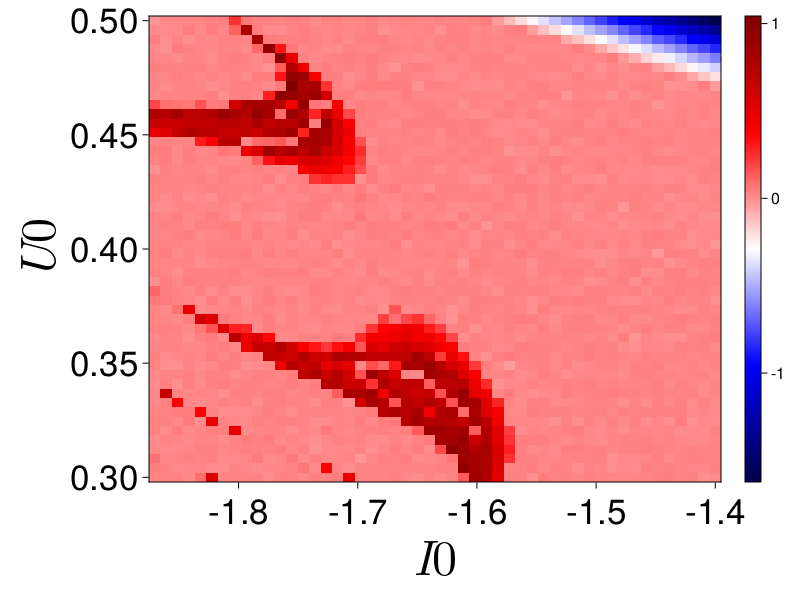

In [64]:
f = Figure()
ax1 = Axis(f[1, 1], xlabel = L"I0",ylabel = L"U0", xlabelsize = 50, ylabelsize = 50,
            xticklabelsize = 35, yticklabelsize = 35,
            xgridvisible  = false, ygridvisible = false)

hm = heatmap!(ax1, I0range, U0range, Λs[:, :, 1], colormap = :seismic)
Colorbar(f[1, 2], hm)
f